## Predict power output given a set of environmental readings from various sensors in a natural gas-fired power generation plant

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.  
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.

Features consist of hourly average ambient variables 
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

### Modelling steps
1. Library imports
2. Dataset understanding
3. Variable relationships

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
random_state = 42

In [3]:
df = pd.read_excel('Data/Folds5x2_pp.xlsx')

## Dataset Understanding

In [4]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [5]:
df.shape

(9568, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
AT    9568 non-null float64
V     9568 non-null float64
AP    9568 non-null float64
RH    9568 non-null float64
PE    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB


In [7]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


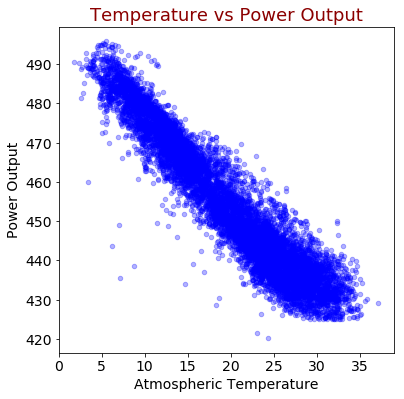

In [8]:
df.plot(x ='AT', y = 'PE', kind ="scatter", 
                 figsize = [6,6],
                 color ="b", alpha = 0.3, 
                fontsize = 14)
plt.title("Temperature vs Power Output", 
          fontsize = 18, color="darkred")
plt.xlabel("Atmospheric Temperature", fontsize = 14) 
plt.ylabel("Power Output", fontsize = 14)
plt.show()

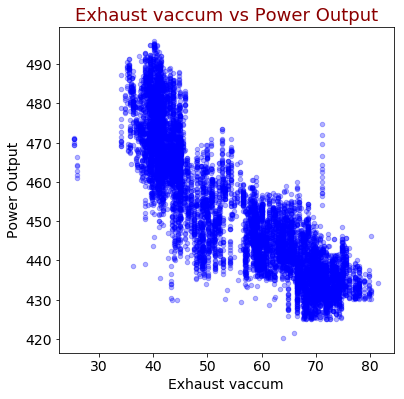

In [9]:
df.plot(x ='V', y = 'PE', kind ="scatter", 
                 figsize = [6,6],
                 color ="b", alpha = 0.3, 
                fontsize = 14)
plt.title("Exhaust vaccum vs Power Output", 
          fontsize = 18, color="darkred")
plt.xlabel("Exhaust vaccum", fontsize = 14) 
plt.ylabel("Power Output", fontsize = 14)
plt.show()

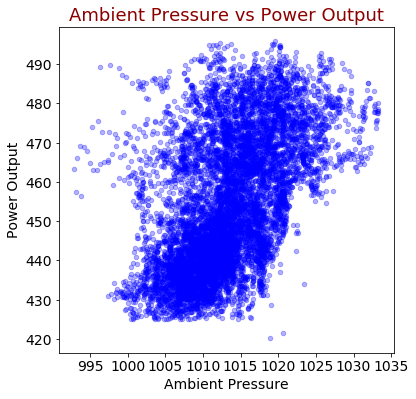

In [10]:
df.plot(x ='AP', y = 'PE', kind ="scatter", 
                 figsize = [6,6],
                 color ="b", alpha = 0.3, 
                fontsize = 14)
plt.title("Ambient Pressure vs Power Output", 
          fontsize = 18, color="darkred")
plt.xlabel("Ambient Pressure", fontsize = 14) 
plt.ylabel("Power Output", fontsize = 14)
plt.show()

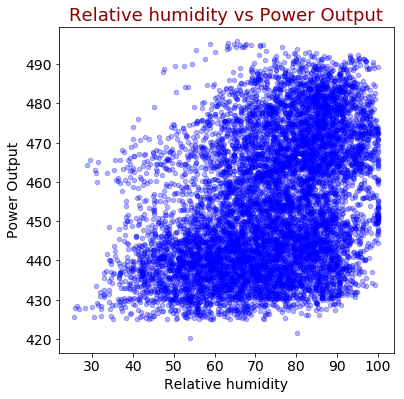

In [11]:
df.plot(x ='RH', y = 'PE', kind ="scatter", 
                 figsize = [6,6],
                 color ="b", alpha = 0.3, 
                fontsize = 14)
plt.title("Relative humidity vs Power Output", 
          fontsize = 18, color="darkred")
plt.xlabel("Relative humidity", fontsize = 14) 
plt.ylabel("Power Output", fontsize = 14)
plt.show()

In [12]:
corelation_mat = df.corr()
corelation_mat

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


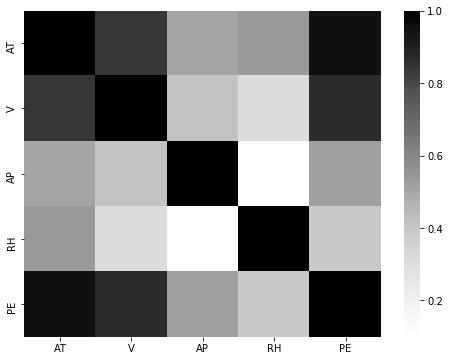

In [13]:
corelation_mat = corelation_mat.abs()
plt.figure(figsize = (8, 6))
sns.heatmap(corelation_mat, cmap="Greys",
            xticklabels=corelation_mat.columns.values,
            yticklabels=corelation_mat.columns.values)
plt.show()

High collinearity between variables and target  
But multicollinearity also present between variables

## LinearRegression

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.feature_selection import f_regression

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
X = df.drop('PE',axis=1).values
y = df.PE.values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=random_state)

In [17]:
scalerX = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.transform(X_test)

In [18]:
var_metrics = f_regression(X_train_scaled, y_train)
pd.DataFrame(data={
    'var_name':df.drop('PE',axis=1).columns,
    'F-score' : var_metrics[0],
    'p-value' : var_metrics[1]})

,var_name,F-score,p-value
0,AT,67803.857428,0.000000e+00
1,V,23701.660696,0.000000e+00
2,AP,2816.767782,0.000000e+00
3,RH,1370.500259,4.085231e-276


In [19]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(X_train_scaled, y_train)
y_train_predict_linear_reg = linear_reg.predict(X_train_scaled)
y_test_predict_linear_reg = linear_reg.predict(X_test_scaled)

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [20]:
print('R squared is {}'.format(linear_reg.score(X_train_scaled, y_train)))
print('RMSE for train is {}'.format(np.sqrt(mean_squared_error(y_train, y_train_predict_linear_reg))))
print('MAE for train is {}'.format(mean_absolute_error(y_train, y_train_predict_linear_reg)))
print('RMSE for test is {}'.format(np.sqrt(mean_squared_error(y_test, y_test_predict_linear_reg))))
print('MAE for test is {}'.format(mean_absolute_error(y_test, y_test_predict_linear_reg)))

R squared is 0.928331545565795
RMSE for train is 4.570930584824314
MAE for train is 3.6299902977038045
RMSE for test is 4.502633229532186
MAE for test is 3.595913178273408


#### Model performance
Model is not overfitting since test sample accuracy is same as train

In [21]:
print('Intercept is {}'.format(linear_reg.intercept_))
print('Coefficients are')
list(zip(df.drop('PE',axis=1).columns, linear_reg.coef_))

Intercept is 454.4310399790958
Coefficients are


[('AT', -14.763927385645413),
 ('V', -2.9496320985616373),
 ('AP', 0.3697803165608674),
 ('RH', -2.3121956560685857)]

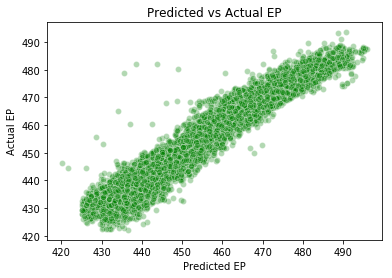

In [22]:
## Plot predictions vs actuals
ax = sns.scatterplot(x=y_train, y=y_train_predict_linear_reg, color = "g",
         alpha = 0.3, markers=True)
plt.plot(x=y_train, y=y_train, linewidth= 100, color="r")
plt.title('Predicted vs Actual EP')
plt.xlabel('Predicted EP')
plt.ylabel('Actual EP')
plt.show()

#### Check test and performance as a function of order of input terms

In [23]:
linear_reg_order_perf_df = pd.DataFrame()

In [24]:
for order in list(range(1,12)):
    temp_linear_reg_poly = LinearRegression(n_jobs=-1)
    poly_features = PolynomialFeatures(order, include_bias=False)
    temp_X_train_scaled_poly = poly_features.fit_transform(X_train)
    temp_X_test_scaled_poly = poly_features.transform(X_test)
    temp_linear_reg_poly.fit(temp_X_train_scaled_poly, y_train)
    temp_y_train_predict_linear_reg_poly = temp_linear_reg_poly.predict(temp_X_train_scaled_poly)
    temp_y_test_predict_linear_reg_poly = temp_linear_reg_poly.predict(temp_X_test_scaled_poly)
    temp_linear_reg_perf_df = pd.DataFrame({
        'order' : [order],
        'train_rmse': [np.sqrt(mean_squared_error(y_train, temp_y_train_predict_linear_reg_poly))],
        'train_mae': [mean_absolute_error(y_train, temp_y_train_predict_linear_reg_poly)],
        'test_rmse': [np.sqrt(mean_squared_error(y_test, temp_y_test_predict_linear_reg_poly))],
        'test_mae': [mean_absolute_error(y_test, temp_y_test_predict_linear_reg_poly)],
        'zero_coef_count':[np.sum(np.abs(temp_linear_reg_poly.coef_)==0)],
        'total_coef':[temp_X_train_scaled_poly.shape[1]]
    })
    linear_reg_order_perf_df = linear_reg_order_perf_df.append(temp_linear_reg_perf_df,ignore_index=True)

In [25]:
linear_reg_order_perf_df['zero_coef_count_perc'] = \
    linear_reg_order_perf_df.zero_coef_count/linear_reg_order_perf_df.total_coef*100

In [26]:
linear_reg_order_perf_df

,order,train_rmse,train_mae,test_rmse,test_mae,zero_coef_count,total_coef,zero_coef_count_perc
0,1,4.570931,3.629990,4.502633,3.595913,0,4,0.0
1,2,4.261402,3.348581,4.231200,3.351350,0,14,0.0
2,3,4.161328,3.228277,4.107231,3.221318,0,34,0.0
3,4,4.093882,3.154554,4.059338,3.163750,0,69,0.0
4,5,4.017504,3.078138,3.980106,3.094636,0,125,0.0
5,6,3.965922,3.024460,3.978227,3.066441,0,209,0.0
6,7,3.926281,2.986442,4.002358,3.059096,0,329,0.0
7,8,3.910270,2.971639,4.006044,3.067772,0,494,0.0
8,9,3.909560,2.971091,4.007050,3.067905,0,714,0.0
9,10,3.909100,2.970684,4.008774,3.067697,0,1000,0.0


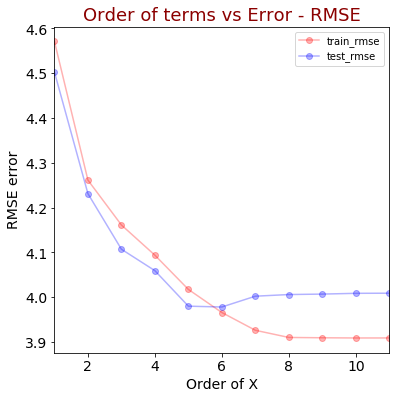

In [27]:
ax = linear_reg_order_perf_df.plot(x ='order', y = ['train_rmse','test_rmse'],
    kind ="line", figsize = [6,6], color =['r','b'], alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - RMSE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("RMSE error", fontsize = 14)
plt.show()

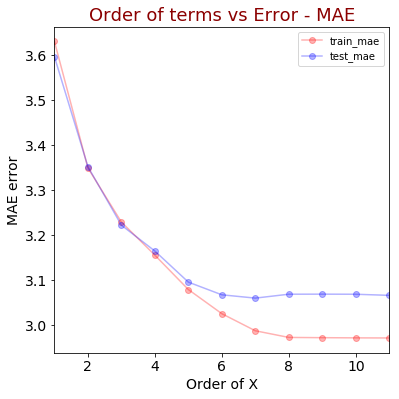

In [28]:
ax = linear_reg_order_perf_df.plot(x ='order', y = ['train_mae','test_mae'],
    kind ="line", figsize = [6,6], color =['r','b'], alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - MAE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("MAE error", fontsize = 14)
plt.show()

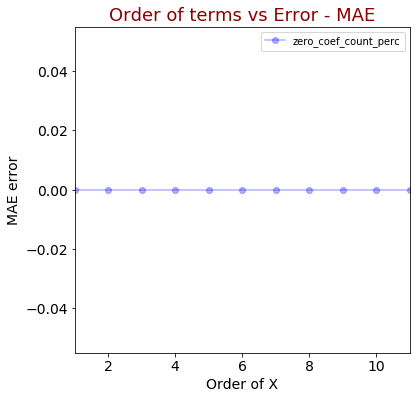

In [29]:
ax = linear_reg_order_perf_df.plot(x ='order', y = 'zero_coef_count_perc',
    kind ="line", figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - MAE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("MAE error", fontsize = 14)
plt.show()

#### Was able to significantly reduce error by introducing higher order terms

#### Check test and performance as a function of number of rows in training data

In [30]:
linear_reg_perf_df = pd.DataFrame()

In [31]:
for row_count in [10, 30, 50, 100, 500, 1000, 2500, 5000, len(X_train_scaled)]:
    temp_linear_reg = LinearRegression(n_jobs=-1)
    random.seed(random_state)
    select_rows = random.sample(list(range(0,len(X_train_scaled))), row_count)
    selected_X_train = X_train_scaled[select_rows,:]
    selected_y_train = y_train[select_rows]
    temp_linear_reg.fit(selected_X_train, selected_y_train)
    temp_y_train_predict_linear_reg = temp_linear_reg.predict(selected_X_train)
    temp_y_test_predict_linear_reg = temp_linear_reg.predict(X_test_scaled)
    temp_linear_reg_perf_df = pd.DataFrame({
        'row_count' : [row_count],
        'train_rmse': [np.sqrt(mean_squared_error(selected_y_train, temp_y_train_predict_linear_reg))],
        'train_mae': [mean_absolute_error(selected_y_train, temp_y_train_predict_linear_reg)],
        'test_rmse': [np.sqrt(mean_squared_error(y_test, temp_y_test_predict_linear_reg))],
        'test_mae': [mean_absolute_error(y_test, temp_y_test_predict_linear_reg)],
    })
    linear_reg_perf_df = linear_reg_perf_df.append(temp_linear_reg_perf_df,ignore_index=True)

In [32]:
linear_reg_perf_df

,row_count,train_rmse,train_mae,test_rmse,test_mae
0,10,1.835914,1.562390,6.358759,4.907398
1,30,3.931334,2.997221,5.546896,4.300476
2,50,4.075155,3.340928,5.071087,3.923324
3,100,4.437137,3.645562,4.594953,3.676422
4,500,4.539067,3.722846,4.523302,3.612895
5,1000,4.530335,3.691833,4.528917,3.615060
6,2500,4.579715,3.648711,4.503992,3.598108
7,5000,4.510692,3.612358,4.507555,3.594542
8,7654,4.570931,3.629990,4.502633,3.595913


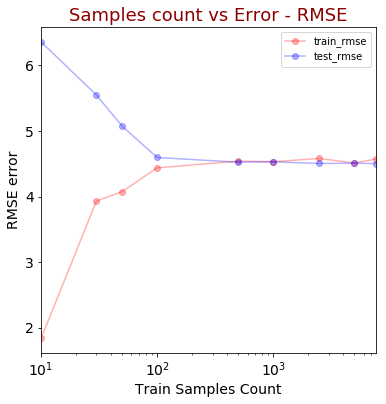

In [33]:
ax = linear_reg_perf_df.plot(x ='row_count', y = ['train_rmse','test_rmse'],
    kind ="line", figsize = [6,6], color =['r','b'], alpha = 0.3, fontsize = 14, marker='o')
plt.title("Samples count vs Error - RMSE", fontsize = 18, color="darkred")
plt.xlabel("Train Samples Count", fontsize = 14) 
plt.ylabel("RMSE error", fontsize = 14)
ax.set_xscale('log')
plt.show()

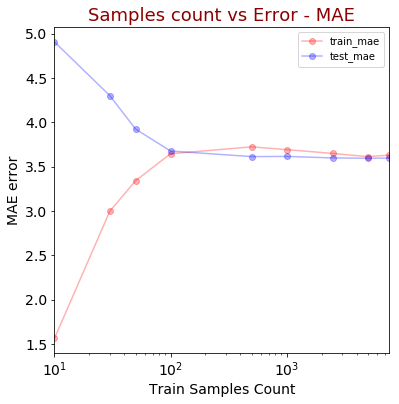

In [34]:
ax = linear_reg_perf_df.plot(x ='row_count', y = ['train_mae','test_mae'],
    kind ='line', figsize = [6,6], color =['r','b'], alpha = 0.3, fontsize = 14, marker='o')
plt.title("Samples count vs Error - MAE", fontsize = 18, color="darkred")
plt.xlabel("Train Samples Count", fontsize = 14) 
plt.ylabel("MAE error", fontsize = 14)
ax.set_xscale('log')
plt.show()

## Lasso Linear Regression

In [35]:
lasso = Lasso(random_state=random_state)
lasso.fit(X_train_scaled, y_train)
y_train_predict_lasso = lasso.predict(X_train_scaled)
y_test_predict_lasso = lasso.predict(X_test_scaled)

In [36]:
print('R squared is {}'.format(lasso.score(X_train_scaled, y_train)))
print('RMSE for train is {}'.format(np.sqrt(mean_squared_error(y_train, y_train_predict_lasso))))
print('MAE for train is {}'.format(mean_absolute_error(y_train, y_train_predict_lasso)))
print('RMSE for test is {}'.format(np.sqrt(mean_squared_error(y_test, y_test_predict_lasso))))
print('MAE for test is {}'.format(mean_absolute_error(y_test, y_test_predict_lasso)))

R squared is 0.9129297742387136
RMSE for train is 5.038200444815834
MAE for train is 4.0241362943955705
RMSE for test is 4.943133196423315
MAE for test is 3.9461006085541355


#### Model performance
Model is worse off as compared to linear regression with default parameter of alpha

### Lasso CV

In [37]:
lasso_cv = LassoCV(cv=5, verbose=True,n_jobs=-1,random_state=random_state, eps=1e-6, n_alphas=1000)
lasso_cv.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=5, eps=1e-06, fit_intercept=True,
    max_iter=1000, n_alphas=1000, n_jobs=-1, normalize=False,
    positive=False, precompute='auto', random_state=42, selection='cyclic',
    tol=0.0001, verbose=True)

In [38]:
lasso_cv.alpha_

0.00044726279131466194

In [39]:
alpha_perf_df = pd.DataFrame({
    'alpha':lasso_cv.alphas_,
    'rmse_error':np.sqrt([np.mean(x) for x in lasso_cv.mse_path_])})

In [40]:
alpha_perf_df

,alpha,rmse_error
0,16.185321,17.066840
1,15.963030,16.866451
2,15.743791,16.659033
3,15.527563,16.454765
4,15.314305,16.253606
5,15.103976,16.055517
6,14.896536,15.860458
7,14.691945,15.668391
8,14.490163,15.479277
9,14.291153,15.293079


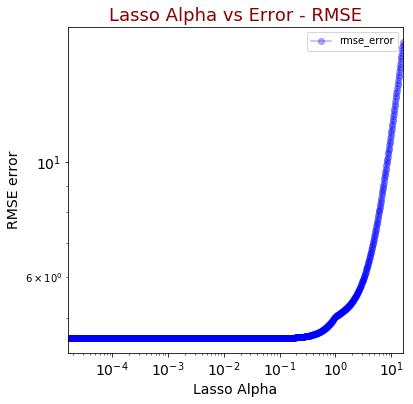

In [41]:
ax = alpha_perf_df.plot(x ='alpha', y = ['rmse_error'],
    kind ='line', figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Lasso Alpha vs Error - RMSE", fontsize = 18, color="darkred")
plt.xlabel("Lasso Alpha", fontsize = 14) 
plt.ylabel("RMSE error", fontsize = 14)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [42]:
y_train_predict_lasso_cv = lasso_cv.predict(X_train_scaled)
y_test_predict_lasso_cv = lasso_cv.predict(X_test_scaled)

In [43]:
print('R squared is {}'.format(lasso_cv.score(X_train_scaled, y_train)))
print('RMSE for train is {}'.format(np.sqrt(mean_squared_error(y_train, y_train_predict_lasso_cv))))
print('MAE for train is {}'.format(mean_absolute_error(y_train, y_train_predict_lasso_cv)))
print('RMSE for test is {}'.format(np.sqrt(mean_squared_error(y_test, y_test_predict_lasso_cv))))
print('MAE for test is {}'.format(mean_absolute_error(y_test, y_test_predict_lasso_cv)))

R squared is 0.9283315404360332
RMSE for train is 4.5709307484094275
MAE for train is 3.62994570688001
RMSE for test is 4.50266005314189
MAE for test is 3.5959011517951196


In [44]:
print('Intercept is {}'.format(lasso_cv.intercept_))
print('Coefficients are')
list(zip(df.drop('PE',axis=1).columns, lasso_cv.coef_))

Intercept is 454.4310399790958
Coefficients are


[('AT', -14.766383008418632),
 ('V', -2.9477032578241236),
 ('AP', 0.36894346223773716),
 ('RH', -2.3123982209336256)]

### Lasso LARS CV

In [45]:
lasso_lars_cv = LassoLarsCV(cv=5, verbose=True,n_jobs=-1, max_iter=1000,eps=1e-15, max_n_alphas=1000)
lasso_lars_cv.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


LassoLarsCV(copy_X=True, cv=5, eps=1e-15, fit_intercept=True, max_iter=1000,
      max_n_alphas=1000, n_jobs=-1, normalize=True, positive=False,
      precompute='auto', verbose=True)

In [46]:
lasso_lars_cv.alpha_

0.0

In [47]:
alpha_perf_df = pd.DataFrame({
    'alpha':lasso_lars_cv.cv_alphas_,
    'rmse_error':np.sqrt([np.mean(x) for x in lasso_lars_cv.mse_path_])})

In [48]:
alpha_perf_df

,alpha,rmse_error
0,0.000000,4.573755
1,0.012530,5.024223
2,0.012850,5.042995
3,0.012860,5.043484
4,0.013109,5.053444
5,0.013124,5.053895
6,0.016469,5.138375
7,0.017082,5.154640
8,0.018083,5.180716
9,0.018300,5.186271


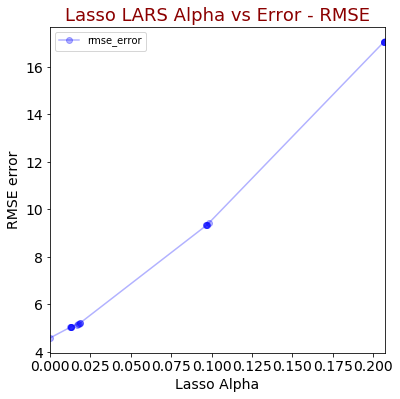

In [49]:
ax = alpha_perf_df.plot(x ='alpha', y = ['rmse_error'],
    kind ='line', figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Lasso LARS Alpha vs Error - RMSE", fontsize = 18, color="darkred")
plt.xlabel("Lasso Alpha", fontsize = 14) 
plt.ylabel("RMSE error", fontsize = 14)
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

In [50]:
y_train_predict_lasso_lars_cv = lasso_lars_cv.predict(X_train_scaled)
y_test_predict_lasso_lars_cv = lasso_lars_cv.predict(X_test_scaled)

In [51]:
print('R squared is {}'.format(lasso_lars_cv.score(X_train_scaled, y_train)))
print('RMSE for train is {}'.format(np.sqrt(mean_squared_error(y_train, y_train_predict_lasso_lars_cv))))
print('MAE for train is {}'.format(mean_absolute_error(y_train, y_train_predict_lasso_lars_cv)))
print('RMSE for test is {}'.format(np.sqrt(mean_squared_error(y_test, y_test_predict_lasso_lars_cv))))
print('MAE for test is {}'.format(mean_absolute_error(y_test, y_test_predict_lasso_lars_cv)))

R squared is 0.928331545565795
RMSE for train is 4.570930584824314
MAE for train is 3.6299902977038054
RMSE for test is 4.502633229532186
MAE for test is 3.5959131782734084


In [52]:
print('Intercept is {}'.format(lasso_lars_cv.intercept_))
print('Coefficients are')
list(zip(df.drop('PE',axis=1).columns, lasso_lars_cv.coef_))

Intercept is 454.4310399790958
Coefficients are


[('AT', -14.763927385645387),
 ('V', -2.9496320985616604),
 ('AP', 0.36978031656088167),
 ('RH', -2.3121956560685875)]

### Lasso higher dimensions

#### Lasso CV

In [71]:
lasso_order_perf_df = pd.DataFrame()

In [70]:
LassoCV?

In [73]:
for order in list(range(1,12)):
    temp_lasso_poly = LassoCV(cv=5, verbose=False,n_jobs=-1,random_state=random_state,
                              eps=1e-6, n_alphas=1000,  max_iter=10000)
    poly_features = PolynomialFeatures(order, include_bias=False)
    temp_X_train_scaled_poly = poly_features.fit_transform(X_train)
    temp_X_test_scaled_poly = poly_features.transform(X_test)
    temp_lasso_poly.fit(temp_X_train_scaled_poly, y_train)
    temp_y_train_predict_lasso_poly = temp_lasso_poly.predict(temp_X_train_scaled_poly)
    temp_y_test_predict_lasso_poly = temp_lasso_poly.predict(temp_X_test_scaled_poly)
    temp_lasso_perf_df = pd.DataFrame({
        'order' : [order],
        'alpha' : [temp_lasso_poly.alpha_],
        'train_rmse': [np.sqrt(mean_squared_error(y_train, temp_y_train_predict_lasso_poly))],
        'train_mae': [mean_absolute_error(y_train, temp_y_train_predict_lasso_poly)],
        'test_rmse': [np.sqrt(mean_squared_error(y_test, temp_y_test_predict_lasso_poly))],
        'test_mae': [mean_absolute_error(y_test, temp_y_test_predict_lasso_poly)],
        'zero_coef_count':[np.sum(np.abs(temp_lasso_poly.coef_)==0)],
        'total_coef':[temp_X_train_scaled_poly.shape[1]]
    })
    lasso_order_perf_df = lasso_order_perf_df.append(temp_lasso_perf_df,ignore_index=True)

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [74]:
lasso_order_perf_df['zero_coef_count_perc'] = \
    lasso_order_perf_df.zero_coef_count/lasso_order_perf_df.total_coef*100

In [76]:
lasso_order_perf_df['non_zero_coef_count'] = \
    lasso_order_perf_df.total_coef - lasso_order_perf_df.zero_coef_count

In [82]:
lasso_order_perf_df

,order,alpha,train_rmse,train_mae,test_rmse,test_mae,zero_coef_count,total_coef,zero_coef_count_perc,non_zero_coef_count
11,1,3.689622e-03,4.570931,3.629929,4.502665,3.595906,0,4,0.000000,4
12,2,1.909115e-01,4.327083,3.420732,4.303192,3.427590,4,14,28.571429,10
13,3,1.878716e+02,4.317948,3.402917,4.293502,3.408817,22,34,64.705882,12
14,4,2.199939e+05,4.333713,3.417613,4.309469,3.424651,57,69,82.608696,12
15,5,2.790319e+08,4.352098,3.435351,4.327863,3.443849,113,125,90.400000,12
16,6,3.397663e+11,4.372196,3.454534,4.347884,3.464133,198,209,94.736842,11
17,7,4.022391e+14,4.393782,3.474565,4.369288,3.484866,318,329,96.656535,11
18,8,4.664933e+17,4.417041,3.495643,4.392364,3.506540,483,494,97.773279,11
19,9,5.325730e+20,4.441963,3.517629,4.417106,3.529253,702,714,98.319328,12
20,10,6.005232e+23,4.467006,3.539315,4.441768,3.551123,988,1000,98.800000,12


In [83]:
alpha_perf_df = pd.DataFrame({
    'alpha':temp_lasso_poly.alphas_,
    'rmse_error':np.sqrt([np.mean(x) for x in temp_lasso_poly.mse_path_])})

In [84]:
alpha_perf_df

,alpha,rmse_error
0,6.703903e+32,17.061371
1,6.611831e+32,17.015454
2,6.521023e+32,16.953519
3,6.431462e+32,16.893056
4,6.343132e+32,16.834034
5,6.256014e+32,16.776423
6,6.170093e+32,16.720192
7,6.085352e+32,16.665313
8,6.001775e+32,16.611757
9,5.919346e+32,16.559495


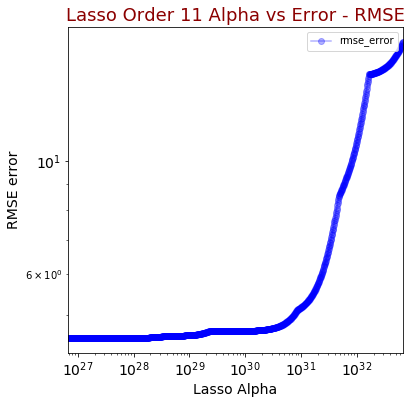

In [85]:
ax = alpha_perf_df.plot(x ='alpha', y = ['rmse_error'],
    kind ='line', figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Lasso Order 11 Alpha vs Error - RMSE", fontsize = 18, color="darkred")
plt.xlabel("Lasso Alpha", fontsize = 14) 
plt.ylabel("RMSE error", fontsize = 14)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

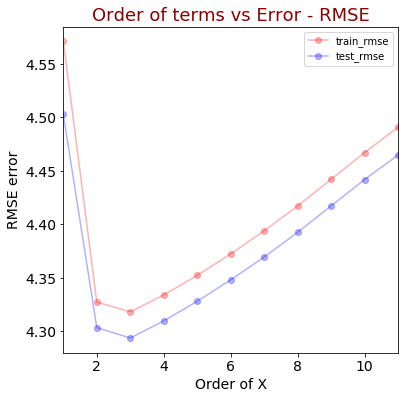

In [86]:
ax = lasso_order_perf_df.plot(x ='order', y = ['train_rmse','test_rmse'],
    kind ="line", figsize = [6,6], color =['r','b'], alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - RMSE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("RMSE error", fontsize = 14)
plt.show()

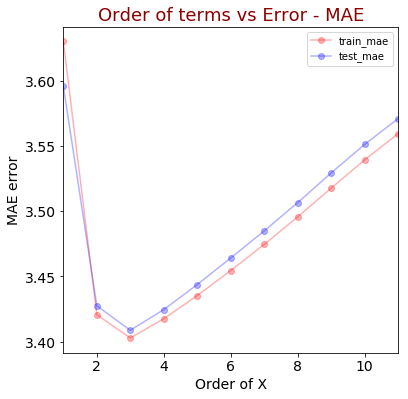

In [87]:
ax = lasso_order_perf_df.plot(x ='order', y = ['train_mae','test_mae'],
    kind ="line", figsize = [6,6], color =['r','b'], alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - MAE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("MAE error", fontsize = 14)
plt.show()

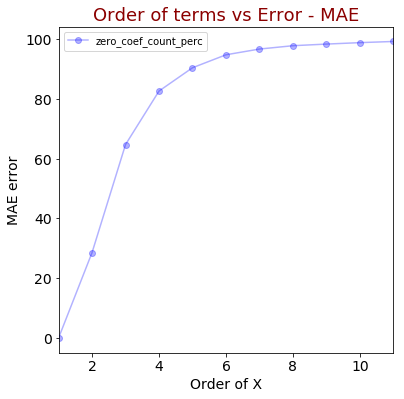

In [89]:
ax = lasso_order_perf_df.plot(x ='order', y = 'zero_coef_count_perc',
    kind ="line", figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - MAE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("MAE error", fontsize = 14)
plt.show()

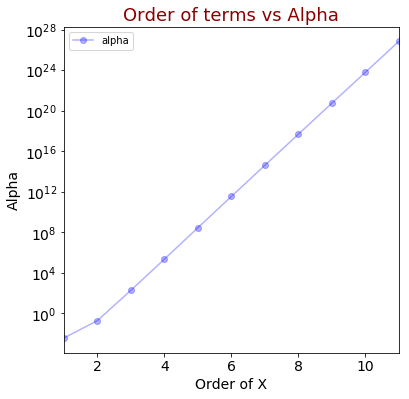

In [90]:
ax = lasso_order_perf_df.plot(x ='order', y = 'alpha',
    kind ="line", figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Alpha", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("Alpha", fontsize = 14)
ax.set_yscale('log')
plt.show()

#### Lasso lars CV

In [91]:
lasso_order_perf_df = pd.DataFrame()

In [92]:
for order in list(range(1,12)):
    temp_lasso_poly = LassoLarsCV(cv=5, verbose=False,n_jobs=-1, max_iter=10000,eps=1e-15, max_n_alphas=1000)
    poly_features = PolynomialFeatures(order, include_bias=False)
    temp_X_train_scaled_poly = poly_features.fit_transform(X_train)
    temp_X_test_scaled_poly = poly_features.transform(X_test)
    temp_lasso_poly.fit(temp_X_train_scaled_poly, y_train)
    temp_y_train_predict_lasso_poly = temp_lasso_poly.predict(temp_X_train_scaled_poly)
    temp_y_test_predict_lasso_poly = temp_lasso_poly.predict(temp_X_test_scaled_poly)
    temp_lasso_perf_df = pd.DataFrame({
        'order' : [order],
        'alpha' : [temp_lasso_poly.alpha_],
        'train_rmse': [np.sqrt(mean_squared_error(y_train, temp_y_train_predict_lasso_poly))],
        'train_mae': [mean_absolute_error(y_train, temp_y_train_predict_lasso_poly)],
        'test_rmse': [np.sqrt(mean_squared_error(y_test, temp_y_test_predict_lasso_poly))],
        'test_mae': [mean_absolute_error(y_test, temp_y_test_predict_lasso_poly)],
        'zero_coef_count':[np.sum(np.abs(temp_lasso_poly.coef_)==0)],
        'total_coef':[temp_X_train_scaled_poly.shape[1]]
    })
    lasso_order_perf_df = lasso_order_perf_df.append(temp_lasso_perf_df,ignore_index=True)

In [93]:
lasso_order_perf_df['zero_coef_count_perc'] = \
    lasso_order_perf_df.zero_coef_count/lasso_order_perf_df.total_coef*100

In [94]:
lasso_order_perf_df['non_zero_coef_count'] = \
    lasso_order_perf_df.total_coef - lasso_order_perf_df.zero_coef_count

In [95]:
lasso_order_perf_df

,order,alpha,train_rmse,train_mae,test_rmse,test_mae,zero_coef_count,total_coef,zero_coef_count_perc,non_zero_coef_count
0,1,0.000000e+00,4.570931,3.629990,4.502633,3.595913,0,4,0.000000,4
1,2,0.000000e+00,4.261402,3.348581,4.231200,3.351350,0,14,0.000000,14
2,3,5.468971e-08,4.173568,3.244229,4.118087,3.232789,6,34,17.647059,28
3,4,1.128109e-07,4.136494,3.210476,4.090396,3.209224,29,69,42.028986,40
4,5,1.171614e-07,4.110955,3.186733,4.055847,3.184954,79,125,63.200000,46
5,6,1.157356e-07,4.090956,3.164378,4.042996,3.164090,155,209,74.162679,54
6,7,1.184217e-07,4.068619,3.142451,4.019045,3.140222,269,329,81.762918,60
7,8,1.173643e-07,4.058234,3.132007,4.013667,3.139271,423,494,85.627530,71
8,9,1.179814e-07,4.050534,3.123917,4.020884,3.142410,637,714,89.215686,77
9,10,1.176033e-07,4.037631,3.109199,4.014572,3.134695,913,1000,91.300000,87


In [96]:
alpha_perf_df = pd.DataFrame({
    'alpha':temp_lasso_poly.cv_alphas_,
    'rmse_error':np.sqrt([np.mean(x) for x in temp_lasso_poly.mse_path_])})

In [97]:
alpha_perf_df

,alpha,rmse_error
0,1.183156e-07,4.065919
1,1.192190e-07,4.065967
2,1.195048e-07,4.065989
3,1.198352e-07,4.066018
4,1.199697e-07,4.066028
5,1.201386e-07,4.066039
6,1.203714e-07,4.066054
7,1.204835e-07,4.066062
8,1.208850e-07,4.066090
9,1.210168e-07,4.066098


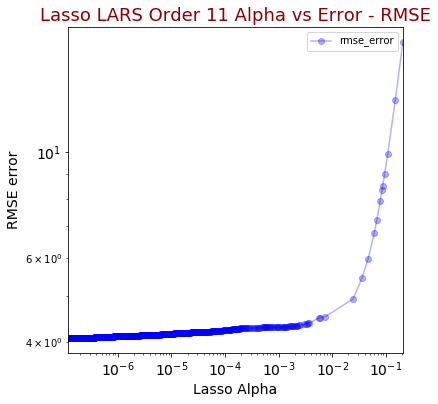

In [103]:
ax = alpha_perf_df.plot(x ='alpha', y = ['rmse_error'],
    kind ='line', figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Lasso LARS Order 11 Alpha vs Error - RMSE", fontsize = 18, color="darkred")
plt.xlabel("Lasso Alpha", fontsize = 14) 
plt.ylabel("RMSE error", fontsize = 14)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

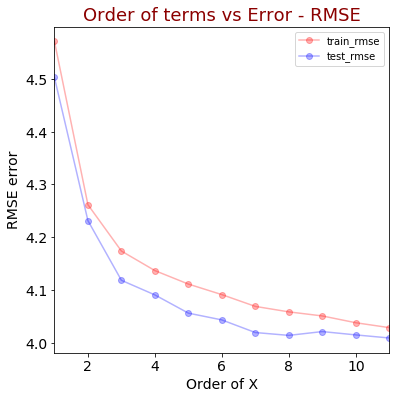

In [99]:
ax = lasso_order_perf_df.plot(x ='order', y = ['train_rmse','test_rmse'],
    kind ="line", figsize = [6,6], color =['r','b'], alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - RMSE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("RMSE error", fontsize = 14)
plt.show()

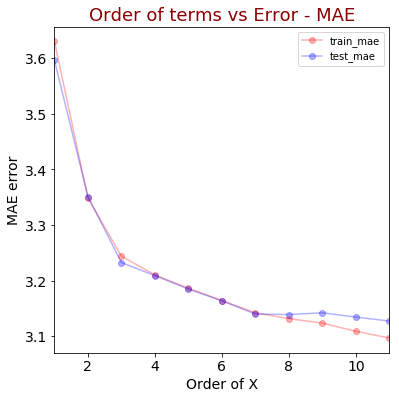

In [100]:
ax = lasso_order_perf_df.plot(x ='order', y = ['train_mae','test_mae'],
    kind ="line", figsize = [6,6], color =['r','b'], alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - MAE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("MAE error", fontsize = 14)
plt.show()

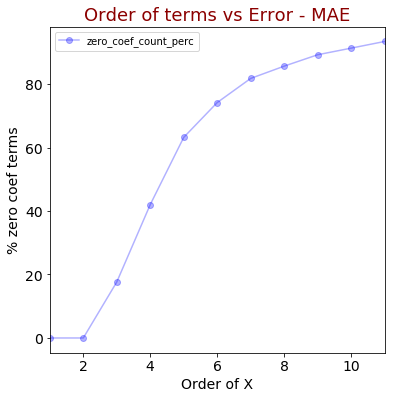

In [104]:
ax = lasso_order_perf_df.plot(x ='order', y = 'zero_coef_count_perc',
    kind ="line", figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - MAE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("% zero coef terms", fontsize = 14)
plt.show()

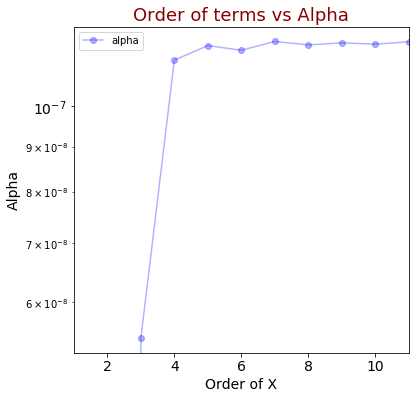

In [105]:
ax = lasso_order_perf_df.plot(x ='order', y = 'alpha',
    kind ="line", figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Alpha", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("Alpha", fontsize = 14)
ax.set_yscale('log')
plt.show()

## Ridge regression

In [106]:
Ridge?

In [58]:
ridge = Ridge(random_state=random_state)
ridge.fit(X_train_scaled, y_train)
y_train_predict_ridge = ridge.predict(X_train_scaled)
y_test_predict_ridge = ridge.predict(X_test_scaled)

In [59]:
print('R squared is {}'.format(ridge.score(X_train_scaled, y_train)))
print('RMSE for train is {}'.format(np.sqrt(mean_squared_error(y_train, y_train_predict_ridge))))
print('MAE for train is {}'.format(mean_absolute_error(y_train, y_train_predict_ridge)))
print('RMSE for test is {}'.format(np.sqrt(mean_squared_error(y_test, y_test_predict_ridge))))
print('MAE for test is {}'.format(mean_absolute_error(y_test, y_test_predict_ridge)))

R squared is 0.9283314811577155
RMSE for train is 4.570932638760015
MAE for train is 3.6301674922303864
RMSE for test is 4.502509880840361
MAE for test is 3.5958524359804955


#### Model performance
Model is similiar to linear regression with default parameter of alpha

In [56]:
RidgeCV?

In [81]:
ridge_cv = RidgeCV(store_cv_values=True,alphas=np.geomspace(1e-6,10,100))
ridge_cv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000e-06, 1.17681e-06, ..., 8.49753e+00, 1.00000e+01]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [82]:
ridge_cv.alpha_

0.2009233002565046

In [84]:
y_train_predict_ridge_cv = ridge_cv.predict(X_train_scaled)
y_test_predict_ridge_cv = ridge_cv.predict(X_test_scaled)

In [85]:
print('R squared is {}'.format(ridge_cv.score(X_train_scaled, y_train)))
print('RMSE for train is {}'.format(np.sqrt(mean_squared_error(y_train, y_train_predict_ridge_cv))))
print('MAE for train is {}'.format(mean_absolute_error(y_train, y_train_predict_ridge_cv)))
print('RMSE for test is {}'.format(np.sqrt(mean_squared_error(y_test, y_test_predict_ridge_cv))))
print('MAE for test is {}'.format(mean_absolute_error(y_test, y_test_predict_ridge_cv)))

R squared is 0.9283315429607302
RMSE for train is 4.570930667898314
MAE for train is 3.6300253097138167
RMSE for test is 4.502608088424112
MAE for test is 3.5959008774959997


In [86]:
print('Intercept is {}'.format(ridge_cv.intercept_))
print('Coefficients are')
list(zip(df.drop('PE',axis=1).columns, ridge_cv.coef_))

Intercept is 454.4310399790958
Coefficients are


[('AT', -14.76182057528672),
 ('V', -2.950908573389029),
 ('AP', 0.3702296546807702),
 ('RH', -2.311432757154762)]

### Higher order terms

In [87]:
ridge_order_perf_df = pd.DataFrame()

In [90]:
for order in list(range(1,12)):
    temp_ridge_poly = RidgeCV(store_cv_values=False,alphas=np.geomspace(1e-6,10,100), cv=5)
    poly_features = PolynomialFeatures(order, include_bias=False)
    temp_X_train_scaled_poly = poly_features.fit_transform(X_train)
    temp_X_test_scaled_poly = poly_features.transform(X_test)
    temp_ridge_poly.fit(temp_X_train_scaled_poly, y_train)
    temp_y_train_predict_ridge_poly = temp_ridge_poly.predict(temp_X_train_scaled_poly)
    temp_y_test_predict_ridge_poly = temp_ridge_poly.predict(temp_X_test_scaled_poly)
    temp_lasso_perf_df = pd.DataFrame({
        'order' : [order],
        'alpha' : [temp_ridge_poly.alpha_],
        'train_rmse': [np.sqrt(mean_squared_error(y_train, temp_y_train_predict_ridge_poly))],
        'train_mae': [mean_absolute_error(y_train, temp_y_train_predict_ridge_poly)],
        'test_rmse': [np.sqrt(mean_squared_error(y_test, temp_y_test_predict_ridge_poly))],
        'test_mae': [mean_absolute_error(y_test, temp_y_test_predict_ridge_poly)],
        'zero_coef_count':[np.sum(np.abs(temp_ridge_poly.coef_)==0)],
        'total_coef':[temp_X_train_scaled_poly.shape[1]]
    })
    ridge_order_perf_df = ridge_order_perf_df.append(temp_lasso_perf_df,ignore_index=True)

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.053142843568224e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.548241872593762e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.203302827299683e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-co

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.298782728010848e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.863951745802897e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.7602254089007e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-cond

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6137060914921142e-23 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5864770817006904e-23 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.526124976824489e-23 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.274612073678899e-23 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.410577948629482e-23 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.252112573279855e-23 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-co

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.84222458711467e-22 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.766357651720367e-22 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.831252024810282e-22 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-con

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.527051700730763e-21 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.571221674591032e-21 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.558093958466367e-21 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-co

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5105229512062814e-20 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5446696748680578e-20 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5357161403727262e-20 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.492033988333624e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.514413955290858e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7696154028159373e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-c

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0685642123175688e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2486618190025806e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2659236651184438e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.3784588957809576e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7902818854141387e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.8221208035380455e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.523101628870021e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.505107357508442e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.3667982275464365e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-c

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.9545740503593423e-30 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.98438743882741e-30 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.3226859047341962e-30 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-c

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.269661686754208e-30 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.16888228909918e-30 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.237527108155249e-30 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-con

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6575981093015795e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6530193103420055e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6235290813782543e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.377447942686488e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.122150266986633e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.1829552675992e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-cond

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1627523122538852e-28 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.360611252992456e-28 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3767384461188794e-28 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.658228029750731e-28 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.5917391427928654e-28 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.635060108610459e-28 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-c

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.716587197084164e-28 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.690196136229031e-28 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.514446763154467e-28 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-co

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.974349905142293e-27 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.0186876358324567e-27 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.53280057903754e-27 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-co

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1108474012596853e-26 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2999740294997196e-26 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3153270330383827e-26 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.235900254983824e-26 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.4354883780232593e-26 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.526663669614728e-26 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-c

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7979720451190438e-25 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7969645214553685e-25 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.76220659898455e-25 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-c

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1018072680683035e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2807905090958519e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3012914466273901e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.271655453255016e-34 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.035604399368097e-35 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.132562828629398e-34 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-co

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6925493887610114e-33 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.297314155889569e-33 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.576505172753533e-34 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-c

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.781587343739375e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.785053385897749e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3124064758166196e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-c

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.709390640605543e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.165035029415099e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.109487839861157e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-co

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.565900373427243e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.0597928999560844e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.075738709822199e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-c

/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.495178374486443e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.265883192004216e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.450278389868925e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/kaustubh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The def

In [91]:
ridge_order_perf_df['zero_coef_count_perc'] = \
    ridge_order_perf_df.zero_coef_count/ridge_order_perf_df.total_coef*100

In [92]:
ridge_order_perf_df['non_zero_coef_count'] = \
    ridge_order_perf_df.total_coef - ridge_order_perf_df.zero_coef_count

In [93]:
ridge_order_perf_df

,order,alpha,train_rmse,train_mae,test_rmse,test_mae,zero_coef_count,total_coef,zero_coef_count_perc,non_zero_coef_count
0,1,10.000000,4.570931,3.630022,4.502609,3.595903,0,4,0.0,4
1,2,0.200923,4.261439,3.348779,4.231339,3.351382,0,14,0.0,14
2,3,0.000004,4.161357,3.228416,4.106818,3.220837,0,34,0.0,34
3,4,0.000001,4.093402,3.154164,4.059290,3.163772,0,69,0.0,69
4,5,0.145083,4.012801,3.073892,3.978133,3.090282,0,125,0.0,125
5,6,10.000000,56.114264,38.143290,65.498885,39.801810,0,209,0.0,209
6,7,0.004751,3.971450,3.024748,4.088518,3.123597,0,329,0.0,329
7,8,0.145083,4.447921,3.389721,4.607517,3.494414,0,494,0.0,494
8,9,0.000001,5.336451,4.021197,6.062753,4.095386,0,714,0.0,714
9,10,0.000001,5.375131,4.076689,5.782697,4.306847,0,1000,0.0,1000


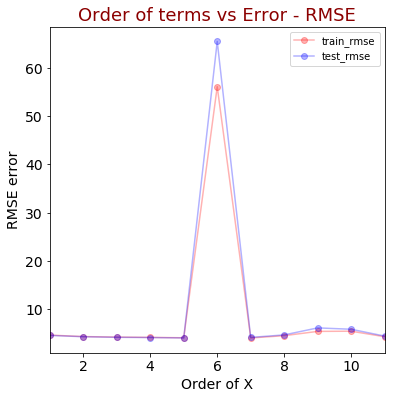

In [94]:
ax = ridge_order_perf_df.plot(x ='order', y = ['train_rmse','test_rmse'],
    kind ="line", figsize = [6,6], color =['r','b'], alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - RMSE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("RMSE error", fontsize = 14)
plt.show()

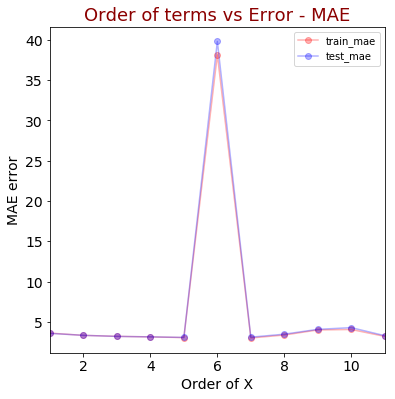

In [95]:
ax = ridge_order_perf_df.plot(x ='order', y = ['train_mae','test_mae'],
    kind ="line", figsize = [6,6], color =['r','b'], alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - MAE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("MAE error", fontsize = 14)
plt.show()

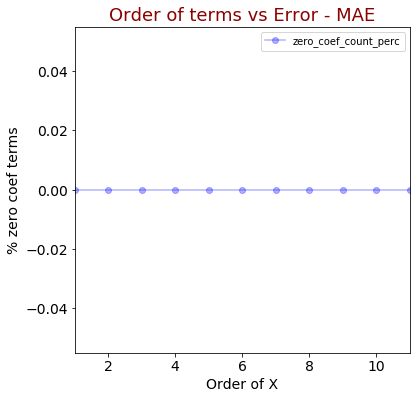

In [96]:
ax = ridge_order_perf_df.plot(x ='order', y = 'zero_coef_count_perc',
    kind ="line", figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Error - MAE", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("% zero coef terms", fontsize = 14)
plt.show()

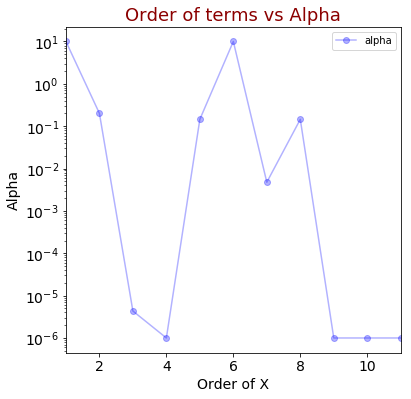

In [97]:
ax = ridge_order_perf_df.plot(x ='order', y = 'alpha',
    kind ="line", figsize = [6,6], color ='b', alpha = 0.3, fontsize = 14, marker='o')
plt.title("Order of terms vs Alpha", fontsize = 18, color="darkred")
plt.xlabel("Order of X", fontsize = 14) 
plt.ylabel("Alpha", fontsize = 14)
ax.set_yscale('log')
plt.show()